In [2]:
from pymongo import MongoClient
import pandas as pd
import numpy as np
from datetime import datetime as dt
import re
from matplotlib import pyplot as plt
import matplotlib
import fastText
import html
import string
import nltk
from multiprocessing import Process
import multiprocessing
import time
import sys
from importlib import reload
import redis
# from urllib import request
from urllib.parse import urlparse
import requests as req
# from lxml import html
import logging
# from scrapy.http import Request
import requests
import json
import requests
from scrapy.http import TextResponse
from bs4 import BeautifulSoup
import re
from collections import Counter
from sklearn.metrics import precision_recall_curve
from tabulate import tabulate
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from gensim.models import Word2Vec
from collections import defaultdict

import pandas as pd
import math
import mpld3
import pickle

mpld3.enable_notebook()
%matplotlib inline

In [3]:
df_comparisons = pd.read_csv('df_comparisons_unsup_lemma.csv', index_col=0)
df_news = pd.read_csv('df_news_unsup_lemma.csv',  parse_dates=['Datetime', 'Date'], index_col=0)

In [4]:
fields = ['title', 'spot','text']

In [5]:
for field in fields:
    df_news[field+'_pp_str'].fillna('', inplace=True)
    df_news[field+'_pp'] = df_news[field+'_pp_str'].apply(lambda x: x.split())

In [6]:
ftmodel = fastText.load_model('../../data/model/downloads/haber-P1_S1_L1-100E.bin')
model_w2v = Word2Vec.load('../../data/model/downloads/reaction.all.1544173485.punct_True.stopwords_True.lemmatized_True.w2v_100V_5E_1547415130.bin')

In [7]:
class IdfCounter:
    
    def __init__(self):
        
        self.counts = Counter()
        self.idfs = {}
        self.N = 0
        
    def add_doc(self, docnow):
        
        self.N += 1
        if self.N % 100_000 == 0:
            print("Processed %i documents" % self.N)
            
        docnow = set(docnow)
        self.counts.update(docnow)
                
    def set_idfs(self):
        
        self.idfs = {}
        for word, count in self.counts.items():
            self.idfs[word] = np.log((self.N - count + 0.5) / (count + 0.5))

In [8]:
idf_counter = IdfCounter()

In [9]:
with open('../../data/haber-P1_S1_L1.txt', 'r') as f:
    for line in f:
        words = line.strip().split()
        idf_counter.add_doc(words)

Processed 100000 documents
Processed 200000 documents
Processed 300000 documents
Processed 400000 documents
Processed 500000 documents
Processed 600000 documents
Processed 700000 documents
Processed 800000 documents
Processed 900000 documents
Processed 1000000 documents
Processed 1100000 documents
Processed 1200000 documents
Processed 1300000 documents
Processed 1400000 documents
Processed 1500000 documents
Processed 1600000 documents
Processed 1700000 documents
Processed 1800000 documents
Processed 1900000 documents
Processed 2000000 documents
Processed 2100000 documents
Processed 2200000 documents
Processed 2300000 documents
Processed 2400000 documents
Processed 2500000 documents
Processed 2600000 documents
Processed 2700000 documents
Processed 2800000 documents
Processed 2900000 documents
Processed 3000000 documents
Processed 3100000 documents
Processed 3200000 documents
Processed 3300000 documents
Processed 3400000 documents
Processed 3500000 documents
Processed 3600000 documents
P

In [10]:
idf_counter.set_idfs()

In [11]:
idf_counter.N

3741375

In [12]:
len(idf_counter.idfs)

3113574

In [13]:
idfs_values = np.array(list(idf_counter.idfs.values()))
max_idf = np.max(idfs_values)
idf_dict = defaultdict(lambda: max_idf, idf_counter.idfs)

In [14]:
def get_idf_w2v(words):
    idfs = []
    for word in words:
        if word in model_w2v.wv.vocab:
            idfs.append(idf_dict[word])
            
    if len(idfs) == 0:
        return np.array([1.]).reshape(-1,1)
    else:
        return np.array(idfs).reshape(-1,1)

In [15]:
for field in fields:
    df_news[field+'_idfs_ft'] = df_news[field+'_pp'].apply(lambda x: np.array([idf_dict[word] for word in x]).reshape(-1,1))
    df_news[field+'_idfs_wv'] = df_news[field+'_pp'].apply(get_idf_w2v)

In [16]:
methods = ['kenter_wv', 'kenter_ft', 'idf_wv', 'idf_ft']

In [17]:
methods_cross = [met + '_' + field for met in methods for field in fields]

In [18]:
def get_w2v_matrix(words_now):
    
    vecs = []
    
    for word in words_now:
        if word in model_w2v.wv.vocab:
            vecs.append(model_w2v.wv.word_vec(word).reshape(1,-1))
    if len(vecs) == 0:
        return np.ones((1,100)) / 10
    else:
        res = np.concatenate(vecs, axis=0)
        return res / np.sqrt((res**2).sum(axis=1, keepdims=True))

In [19]:
def get_ft_matrix(words_now):
    
    if len(words_now) == 0:
        return np.ones((1,100)) / 10
    
    res = np.concatenate([ftmodel.get_word_vector(word).reshape(1,-1) for word in words_now], axis=0)
    return res / np.sqrt((res**2).sum(axis=1, keepdims=True))

In [20]:
for field in fields:
    df_news[field + '_pp_ft_mat'] = df_news[field + '_pp'].apply(get_ft_matrix)
    df_news[field + '_pp_wv_mat'] = df_news[field + '_pp'].apply(get_w2v_matrix)

In [56]:
k1 = 2
b = 0.75
av_len = {field: df_news[field + '_pp'].apply(len).mean() for field in fields} 

In [75]:
ks = [0.8,1,1.2,1.5,2,2.5,5]
bs = [0.2, 0.5, 0.75, 0.9, 1]

In [129]:
ks = [5, 10, 20, 50]
bs = [0, 0.001, 0.01, 0.1, 0.2]

In [130]:
for field in fields:
    
    print(field)
    
    ds_lens = df_news[field + '_pp'].apply(len)
    ds_ft = df_news[field + '_pp_ft_mat']
    ds_wv = df_news[field + '_pp_wv_mat']
    ds_idf_ft = df_news[field+'_idfs_ft']
    ds_idf_wv = df_news[field+'_idfs_wv']
    
    for index, row in df_comparisons.iterrows():
        
        ind0 = int(row.ind0)
        ind1 = int(row.ind1)
        
        if ds_lens.iloc[ind1] == 0 or ds_lens.iloc[ind0] == 0:
            
            res_wv = {'k_'+str(k)+'_b_'+str(b): None for b in bs for k in ks}
            res_ft = {'k_'+str(k)+'_b_'+str(b): None for b in bs for k in ks}
            res_wv_idfonly = None
            res_ft_idfonly = None
        
        else:
        
            if ds_lens.iloc[ind1] > ds_lens.iloc[ind0]:
                tmp = ind1
                ind1 = ind0
                ind0 = tmp

            mat_wv_l = ds_wv.iloc[ind0]
            mat_wv_s = ds_wv.iloc[ind1]

            mat_ft_l = ds_ft.iloc[ind0]
            mat_ft_s = ds_ft.iloc[ind1]

            len_s = ds_lens.iloc[ind1]
            idf_l_ft = ds_idf_ft.iloc[ind0]
            idf_l_wv = ds_idf_wv.iloc[ind0]

            cos_wv = mat_wv_l @ mat_wv_s.transpose()
            cos_ft = mat_ft_l @ mat_ft_s.transpose()

            max_cos_wv = cos_wv.max(axis=1, keepdims=True)
            max_cos_ft = cos_ft.max(axis=1, keepdims=True)
            
            res_wv = {}
            res_ft = {}
            
            for k1 in ks:
                for b in bs:
                    res_wv['k_'+str(k1)+'_b_'+str(b)] = np.mean(idf_l_wv * max_cos_wv * (k1 + 1) / (max_cos_wv + k1 * (1-b+b*len_s / av_len[field]) ))
                    res_ft['k_'+str(k1)+'_b_'+str(b)] = np.mean(idf_l_ft * max_cos_ft * (k1 + 1) / (max_cos_ft + k1 * (1-b+b*len_s / av_len[field]) ))
            
            res_wv_idfonly = np.mean(idf_l_wv * max_cos_wv)
            res_ft_idfonly = np.mean(idf_l_ft * max_cos_ft)
        
        for k1 in ks:
            for b in bs:
                optname = 'k_'+str(k1)+'_b_'+str(b)
                df_comparisons.loc[index, 'kenter_wv_'+optname + '_' + field] = res_wv[optname]
                df_comparisons.loc[index, 'kenter_ft_'+optname + '_' + field] = res_ft[optname]
        
        df_comparisons.loc[index, 'idf_wv_'+field] = res_wv_idfonly
        df_comparisons.loc[index, 'idf_ft_'+field] = res_ft_idfonly

title
spot
text


In [131]:
def prec_recall(tp, fp, fn):

    return float(tp / (tp + fp)), float(tp / (tp + fn))

def find_eacc(labels_now, preds_now):
    
    labels_now = labels_now.flatten()
    preds_now = preds_now.flatten()
    
    precs, recalls, thresholds = precision_recall_curve(labels_now, preds_now)
    
    indnow = np.argmin(np.abs(precs-recalls))
    eacc = (precs[indnow] + recalls[indnow]) / 2
    thr = thresholds[indnow]
    
    true_positive = np.logical_and(preds_now>=thr, labels_now==1).sum()
    true_negative = np.logical_and(preds_now<thr, labels_now==0).sum()
    false_positive = np.logical_and(preds_now>=thr, labels_now==0).sum()
    false_negative = np.logical_and(preds_now<thr, labels_now==1).sum()
    
    precision, recall = prec_recall(true_positive, false_positive, false_negative)
    
    if recall == 0 and precision == 0:
        f1 = 0
    else:
        f1 = 2*(recall * precision) / (recall + precision)
    
    out = dict(thr=thr,eacc=eacc, precision=precision, recall=recall, f1=f1,
              tp=true_positive, tn=true_negative,
               fp=false_positive, fn=false_negative,
               precs=precs, recalls=recalls
               )
    
    return out

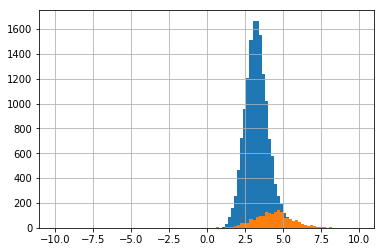

In [132]:
df_comparisons.groupby('label').kenter_ft_text.hist(bins=100, range=[-10,10]);

In [133]:
methods_cross

['kenter_wv_title',
 'kenter_wv_spot',
 'kenter_wv_text',
 'kenter_ft_title',
 'kenter_ft_spot',
 'kenter_ft_text',
 'idf_wv_title',
 'idf_wv_spot',
 'idf_wv_text',
 'idf_ft_title',
 'idf_ft_spot',
 'idf_ft_text']

In [134]:
optcols = []

for k1 in ks:
    for b in bs:
        optname = 'k_'+str(k1)+'_b_'+str(b)
        for field in fields:
            colname = 'kenter_wv_'+optname + '_' + field
            optcols.append(colname)
            colname = 'kenter_ft_'+optname + '_' + field
            optcols.append(colname)

In [135]:
for col in optcols:
    if col not in df_comparisons.columns:
        print(col)

In [136]:
for met in methods_cross + optcols:
    df_comparisons.loc[df_comparisons[met].isnull(), met] = df_comparisons[met].mean()

In [137]:
df_comparisons['label'] = df_comparisons.label.astype(np.int64)

In [138]:
results = {}
for method in methods_cross + optcols:
    results[method] = find_eacc(df_comparisons.label.values, df_comparisons[method].values) 

In [139]:
def tabulate_res(resnow):

    table = []
    for key, val in resnow.items():
        table.append(
            [key, resnow[key]['eacc'], resnow[key]['f1'], resnow[key]['precision'], resnow[key]['recall'], resnow[key]['thr'], resnow[key]['tp'], resnow[key]['tn'], resnow[key]['fp'],
             resnow[key]['fn']])

    return tabulate(table, headers=['', 'E-ACC', 'F1', 'PREC', 'RECALL', 'THR', 'TP', 'TN', 'FP', 'FN'], tablefmt="fancy_grid")

In [141]:
print(tabulate_res(results))

╒══════════════════════════════╤══════════╤══════════╤══════════╤══════════╤═════════╤══════╤═══════╤══════╤══════╕
│                              │    E-ACC │       F1 │     PREC │   RECALL │     THR │   TP │    TN │   FP │   FN │
╞══════════════════════════════╪══════════╪══════════╪══════════╪══════════╪═════════╪══════╪═══════╪══════╪══════╡
│ kenter_wv_title              │ 0.572121 │ 0.572121 │ 0.572121 │ 0.572121 │ 2.90282 │ 1063 │ 14205 │  795 │  795 │
├──────────────────────────────┼──────────┼──────────┼──────────┼──────────┼─────────┼──────┼───────┼──────┼──────┤
│ kenter_wv_spot               │ 0.629171 │ 0.629171 │ 0.629171 │ 0.629171 │ 3.40738 │ 1169 │ 14311 │  689 │  689 │
├──────────────────────────────┼──────────┼──────────┼──────────┼──────────┼─────────┼──────┼───────┼──────┼──────┤
│ kenter_wv_text               │ 0.467169 │ 0.467169 │ 0.467169 │ 0.467169 │ 4.4085  │  868 │ 14010 │  990 │  990 │
├──────────────────────────────┼──────────┼──────────┼──────────┼───────

In [118]:
print(tabulate_res(results))

╒══════════════════════════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│                              │    E-ACC │       F1 │     PREC │   RECALL │      THR │   TP │    TN │   FP │   FN │
╞══════════════════════════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ kenter_wv_title              │ 0.572121 │ 0.572121 │ 0.572121 │ 0.572121 │  2.90282 │ 1063 │ 14205 │  795 │  795 │
├──────────────────────────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────┼───────┼──────┼──────┤
│ kenter_wv_spot               │ 0.629171 │ 0.629171 │ 0.629171 │ 0.629171 │  3.40738 │ 1169 │ 14311 │  689 │  689 │
├──────────────────────────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────┼───────┼──────┼──────┤
│ kenter_wv_text               │ 0.467169 │ 0.467169 │ 0.467169 │ 0.467169 │  4.4085  │  868 │ 14010 │  990 │  990 │
├──────────────────────────────┼──────────┼──────────┼──────────

In [92]:
print(tabulate_res(results))

╒═════════════════╤══════════╤══════════╤══════════╤══════════╤═════════╤══════╤═══════╤══════╤══════╕
│                 │    E-ACC │       F1 │     PREC │   RECALL │     THR │   TP │    TN │   FP │   FN │
╞═════════════════╪══════════╪══════════╪══════════╪══════════╪═════════╪══════╪═══════╪══════╪══════╡
│ kenter_wv_title │ 0.572121 │ 0.572121 │ 0.572121 │ 0.572121 │ 2.90282 │ 1063 │ 14205 │  795 │  795 │
├─────────────────┼──────────┼──────────┼──────────┼──────────┼─────────┼──────┼───────┼──────┼──────┤
│ kenter_wv_spot  │ 0.629171 │ 0.629171 │ 0.629171 │ 0.629171 │ 3.40738 │ 1169 │ 14311 │  689 │  689 │
├─────────────────┼──────────┼──────────┼──────────┼──────────┼─────────┼──────┼───────┼──────┼──────┤
│ kenter_wv_text  │ 0.467169 │ 0.467169 │ 0.467169 │ 0.467169 │ 4.4085  │  868 │ 14010 │  990 │  990 │
├─────────────────┼──────────┼──────────┼──────────┼──────────┼─────────┼──────┼───────┼──────┼──────┤
│ kenter_ft_title │ 0.555436 │ 0.555436 │ 0.555436 │ 0.555436 │ 2.95067 │

In [55]:
print(tabulate_res(results))

╒═════════════════╤══════════╤══════════╤══════════╤══════════╤═════════╤══════╤═══════╤══════╤══════╕
│                 │    E-ACC │       F1 │     PREC │   RECALL │     THR │   TP │    TN │   FP │   FN │
╞═════════════════╪══════════╪══════════╪══════════╪══════════╪═════════╪══════╪═══════╪══════╪══════╡
│ kenter_wv_title │ 0.527449 │ 0.527449 │ 0.527449 │ 0.527449 │ 3.08119 │  980 │ 14122 │  878 │  878 │
├─────────────────┼──────────┼──────────┼──────────┼──────────┼─────────┼──────┼───────┼──────┼──────┤
│ kenter_wv_spot  │ 0.586114 │ 0.586114 │ 0.586114 │ 0.586114 │ 3.50757 │ 1089 │ 14231 │  769 │  769 │
├─────────────────┼──────────┼──────────┼──────────┼──────────┼─────────┼──────┼───────┼──────┼──────┤
│ kenter_wv_text  │ 0.440258 │ 0.440258 │ 0.440258 │ 0.440258 │ 4.34376 │  818 │ 13960 │ 1040 │ 1040 │
├─────────────────┼──────────┼──────────┼──────────┼──────────┼─────────┼──────┼───────┼──────┼──────┤
│ kenter_ft_title │ 0.510764 │ 0.510764 │ 0.510764 │ 0.510764 │ 3.14092 │

In [120]:
with open('unsupervised_results_lemma_kenter.pickle', 'wb') as f:
    pickle.dump(results, f)

In [97]:
def normalize_score(dfnow, colname, thrnow):
    
    stdnow = dfnow[colname].std()
    
    print("%s\t==>\tstd: %.4f, old_thr: %.4f" % (colname, stdnow, thrnow))
    
    return (dfnow[colname] - thrnow ) / stdnow, stdnow

In [142]:
field = 'text'
res_tmp = np.zeros((len(ks), len(bs)))

met = 'kenter_ft'

for ind_k, k1 in enumerate(ks):
    for ind_b, b in enumerate(bs):
        optname = 'k_'+str(k1)+'_b_'+str(b)
        
        colname = met + '_' + optname + '_' + field
        
        res_tmp[ind_k, ind_b] = results[colname]['f1']

In [143]:
print(res_tmp)

[[0.86114101 0.86167922 0.86383208 0.85791173 0.82723358]
 [0.87621098 0.87621098 0.87674919 0.87190527 0.84337998]
 [0.88320775 0.88374596 0.8853606  0.87944026 0.85145318]
 [0.88805167 0.88805167 0.88805167 0.88482239 0.85737352]]


In [127]:
print(res_tmp)

[[0.61679225 0.50484392 0.37674919 0.27502691 0.22174381]
 [0.67061356 0.54413348 0.40419806 0.29386437 0.23035522]
 [0.70559742 0.57481163 0.42734123 0.29763186 0.23681378]
 [0.73896663 0.60710441 0.4467169  0.31001076 0.24273412]
 [0.76964478 0.6350915  0.46340151 0.32077503 0.2416577 ]
 [0.78848224 0.65285253 0.47255113 0.32561895 0.24650161]
 [0.82723358 0.68083961 0.48600646 0.33584499 0.2540366 ]]


In [144]:
ks

[5, 10, 20, 50]

In [145]:
bs

[0, 0.001, 0.01, 0.1, 0.2]

In [147]:
k_opt = 50
b_opt = 0.001

optname = 'k_'+str(k_opt)+'_b_'+str(b_opt)

In [157]:
methods2 = [met+'_'+optname for met in ['kenter_wv','kenter_ft']]
methods_cross_2 = [met + '_' + field for met in methods2 for field in fields]

In [158]:
for method in methods_cross_2:
    dsnow, stdnow = normalize_score(df_comparisons, method, results[method]['thr'])
    df_comparisons[method+'_norm'] = dsnow
    results[method]['std_norm'] = stdnow

kenter_wv_k_50_b_0.001_title	==>	std: 0.6633, old_thr: 2.1393
kenter_wv_k_50_b_0.001_spot	==>	std: 0.6192, old_thr: 2.3531
kenter_wv_k_50_b_0.001_text	==>	std: 0.5445, old_thr: 2.6989
kenter_ft_k_50_b_0.001_title	==>	std: 0.6932, old_thr: 2.1730
kenter_ft_k_50_b_0.001_spot	==>	std: 0.6468, old_thr: 2.3728
kenter_ft_k_50_b_0.001_text	==>	std: 0.5724, old_thr: 2.7569


In [159]:
methods_cross_norm2 = [met+'_norm' for met in methods_cross_2]

In [160]:
field_weights = {'spot': 0.3, 'title': 0.1, 'text': 0.6}

In [161]:
def weighted_av(rownow, weights_field, metsnow):
    
    score = 0
    count = 0
    
    for method in metsnow:
        count += 1
        for field in fields:
            score += weights_field[field] * rownow[method + '_' + field + '_norm']
            
    return score / count

In [162]:
for met in methods2:
    df_comparisons[met + '_all'] = df_comparisons.apply(lambda row: weighted_av(row, field_weights, [met]), axis=1)
    results.update({met + '_all': find_eacc(df_comparisons.label.values, df_comparisons[met + '_all'].values)})

In [163]:
results.update({met+'_all': find_eacc(df_comparisons.label.values, df_comparisons[met+'_all'].values) for met in methods2})

In [164]:
print(tabulate_res(results))

╒══════════════════════════════╤══════════╤══════════╤══════════╤══════════╤════════════╤══════╤═══════╤══════╤══════╕
│                              │    E-ACC │       F1 │     PREC │   RECALL │        THR │   TP │    TN │   FP │   FN │
╞══════════════════════════════╪══════════╪══════════╪══════════╪══════════╪════════════╪══════╪═══════╪══════╪══════╡
│ kenter_wv_title              │ 0.572121 │ 0.572121 │ 0.572121 │ 0.572121 │  2.90282   │ 1063 │ 14205 │  795 │  795 │
├──────────────────────────────┼──────────┼──────────┼──────────┼──────────┼────────────┼──────┼───────┼──────┼──────┤
│ kenter_wv_spot               │ 0.629171 │ 0.629171 │ 0.629171 │ 0.629171 │  3.40738   │ 1169 │ 14311 │  689 │  689 │
├──────────────────────────────┼──────────┼──────────┼──────────┼──────────┼────────────┼──────┼───────┼──────┼──────┤
│ kenter_wv_text               │ 0.467169 │ 0.467169 │ 0.467169 │ 0.467169 │  4.4085    │  868 │ 14010 │  990 │  990 │
├──────────────────────────────┼──────────┼─────

In [165]:
methods2

['kenter_wv_k_50_b_0.001', 'kenter_ft_k_50_b_0.001']

In [166]:
methods_cross_2

['kenter_wv_k_50_b_0.001_title',
 'kenter_wv_k_50_b_0.001_spot',
 'kenter_wv_k_50_b_0.001_text',
 'kenter_ft_k_50_b_0.001_title',
 'kenter_ft_k_50_b_0.001_spot',
 'kenter_ft_k_50_b_0.001_text']

In [167]:
results_final = {}
for method in [met + '_' + field for met in methods2 for field in fields + ['all']]:
    results_final[method] = find_eacc(df_comparisons.label.values, df_comparisons[method].values) 

In [168]:
print(tabulate_res(results_final))

╒══════════════════════════════╤══════════╤══════════╤══════════╤══════════╤════════════╤══════╤═══════╤══════╤══════╕
│                              │    E-ACC │       F1 │     PREC │   RECALL │        THR │   TP │    TN │   FP │   FN │
╞══════════════════════════════╪══════════╪══════════╪══════════╪══════════╪════════════╪══════╪═══════╪══════╪══════╡
│ kenter_wv_k_50_b_0.001_title │ 0.750807 │ 0.750807 │ 0.750807 │ 0.750807 │  2.13926   │ 1395 │ 14537 │  463 │  463 │
├──────────────────────────────┼──────────┼──────────┼──────────┼──────────┼────────────┼──────┼───────┼──────┼──────┤
│ kenter_wv_k_50_b_0.001_spot  │ 0.874058 │ 0.874058 │ 0.874058 │ 0.874058 │  2.35308   │ 1624 │ 14766 │  234 │  234 │
├──────────────────────────────┼──────────┼──────────┼──────────┼──────────┼────────────┼──────┼───────┼──────┼──────┤
│ kenter_wv_k_50_b_0.001_text  │ 0.899354 │ 0.899354 │ 0.899354 │ 0.899354 │  2.69894   │ 1671 │ 14813 │  187 │  187 │
├──────────────────────────────┼──────────┼─────

In [ ]:
methods2 = [met+'_'+optname for met in ['kenter_wv','kenter_ft']]
methods_cross_2 = [met + '_' + field for met in methods2 for field in fields]


In [171]:
methods2

['kenter_wv_k_50_b_0.001', 'kenter_ft_k_50_b_0.001']

In [172]:
met2print = {}
for met in ['kenter_wv', 'kenter_ft']:
    met2 = met+'_'+optname
    for field in fields + ['all']:
        met2print[met2 + '_' + field] = met + '_' + field

In [173]:
met2print

{'kenter_wv_k_50_b_0.001_title': 'kenter_wv_title',
 'kenter_wv_k_50_b_0.001_spot': 'kenter_wv_spot',
 'kenter_wv_k_50_b_0.001_text': 'kenter_wv_text',
 'kenter_wv_k_50_b_0.001_all': 'kenter_wv_all',
 'kenter_ft_k_50_b_0.001_title': 'kenter_ft_title',
 'kenter_ft_k_50_b_0.001_spot': 'kenter_ft_spot',
 'kenter_ft_k_50_b_0.001_text': 'kenter_ft_text',
 'kenter_ft_k_50_b_0.001_all': 'kenter_ft_all'}

In [174]:
results_final2 = {}
for key, val in results_final.items():
    results_final2[met2print[key]] = val

In [176]:
print(tabulate_res(results_final2))

╒═════════════════╤══════════╤══════════╤══════════╤══════════╤════════════╤══════╤═══════╤══════╤══════╕
│                 │    E-ACC │       F1 │     PREC │   RECALL │        THR │   TP │    TN │   FP │   FN │
╞═════════════════╪══════════╪══════════╪══════════╪══════════╪════════════╪══════╪═══════╪══════╪══════╡
│ kenter_wv_title │ 0.750807 │ 0.750807 │ 0.750807 │ 0.750807 │  2.13926   │ 1395 │ 14537 │  463 │  463 │
├─────────────────┼──────────┼──────────┼──────────┼──────────┼────────────┼──────┼───────┼──────┼──────┤
│ kenter_wv_spot  │ 0.874058 │ 0.874058 │ 0.874058 │ 0.874058 │  2.35308   │ 1624 │ 14766 │  234 │  234 │
├─────────────────┼──────────┼──────────┼──────────┼──────────┼────────────┼──────┼───────┼──────┼──────┤
│ kenter_wv_text  │ 0.899354 │ 0.899354 │ 0.899354 │ 0.899354 │  2.69894   │ 1671 │ 14813 │  187 │  187 │
├─────────────────┼──────────┼──────────┼──────────┼──────────┼────────────┼──────┼───────┼──────┼──────┤
│ kenter_wv_all   │ 0.941335 │ 0.941335 │ 0.94

In [177]:
with open('unsupervised_results_lemma_kenter_final.pickle', 'wb') as f:
    pickle.dump(results_final2, f)

In [96]:
results.keys()

dict_keys(['kenter_wv_title', 'kenter_wv_spot', 'kenter_wv_text', 'kenter_ft_title', 'kenter_ft_spot', 'kenter_ft_text', 'idf_wv_title', 'idf_wv_spot', 'idf_wv_text', 'idf_ft_title', 'idf_ft_spot', 'idf_ft_text', 'kenter_wv_k_0.8_b_0.2_title', 'kenter_wv_k_0.8_b_0.2_spot', 'kenter_wv_k_0.8_b_0.2_text', 'kenter_wv_k_0.8_b_0.5_title', 'kenter_wv_k_0.8_b_0.5_spot', 'kenter_wv_k_0.8_b_0.5_text', 'kenter_wv_k_0.8_b_0.75_title', 'kenter_wv_k_0.8_b_0.75_spot', 'kenter_wv_k_0.8_b_0.75_text', 'kenter_wv_k_0.8_b_0.9_title', 'kenter_wv_k_0.8_b_0.9_spot', 'kenter_wv_k_0.8_b_0.9_text', 'kenter_wv_k_0.8_b_1_title', 'kenter_wv_k_0.8_b_1_spot', 'kenter_wv_k_0.8_b_1_text', 'kenter_wv_k_1_b_0.2_title', 'kenter_wv_k_1_b_0.2_spot', 'kenter_wv_k_1_b_0.2_text', 'kenter_wv_k_1_b_0.5_title', 'kenter_wv_k_1_b_0.5_spot', 'kenter_wv_k_1_b_0.5_text', 'kenter_wv_k_1_b_0.75_title', 'kenter_wv_k_1_b_0.75_spot', 'kenter_wv_k_1_b_0.75_text', 'kenter_wv_k_1_b_0.9_title', 'kenter_wv_k_1_b_0.9_spot', 'kenter_wv_k_1_b_0.9